<a href="https://colab.research.google.com/github/radhikasethi2011/btechproj/blob/main/colab_files/k_fold_with_random_state_l%26l_l%26tad_l%26r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

run

In [1]:
!git clone https://github.com/radhikasethi2011/btechproj.git

Cloning into 'btechproj'...
remote: Enumerating objects: 285, done.
remote: Counting objects: 100% (285/285), done.
remote: Compressing objects: 100% (237/237), done.
remote: Total 285 (delta 113), reused 117 (delta 35), pack-reused 0
Receiving objects: 100% (285/285), 19.68 MiB | 7.22 MiB/s, done.
Resolving deltas: 100% (113/113), done.


functional code for generating multiple bed files

run

In [2]:
import pandas as pd 
import numpy as np
#flag=1 -> tad file 
#flag=2 -> left boundry file 
#flag=3 -> rightboundry file 


def bed_file(df, flag,name,shift):
  if flag==1:
    #tad
    tad = (df['chr1_num'] + df['chr2_num']) / 2
    df2 = tad.to_frame()
    df2 = df2.astype('int')
    left = df2[0] - shift 
    left.to_frame()
    right = df2[0] + shift 
    right.to_frame()
    chrom_num = df['chromosome_num']
    df = df.join(left).rename(columns={0: 'left'})
    df = df.join(right).rename(columns={0: 'right'})
    df['.'] = df['chromosome_num'] + str(':') + df['left'].astype('str') + str('-') + df['right'].astype(str)

  elif flag==2:
    #left
    lbx = (df['chr1_num'] - shift-200 )
    lbx=lbx.to_frame()
    lbx=lbx.rename(columns={'chr1_num':'LeftBoundaryX'})
    df=df.join(lbx)
    lby = (df['chr1_num'] - shift )
    lby=lby.to_frame()
    lby=lby.rename(columns={'chr1_num':'LeftBoundaryY'})
    df=df.join(lby)
    df['.'] = df['chromosome_num'] + str(':') +df['LeftBoundaryX'].astype('str') + str('-') + df['LeftBoundaryY'].astype(str)

  elif flag==3:
    #right
    rbx = (df['chr2_num'] + shift )
    rbx=rbx.to_frame()
    rbx=rbx.rename(columns={'chr2_num':'RightBoundaryX'})
    df=df.join(rbx)
    rby = (df['chr2_num'] + shift + 200 )
    rby=rby.to_frame()
    rby=rby.rename(columns={'chr2_num':'RightBoundaryY'})
    df=df.join(rby)
    df['.'] = df['chromosome_num'] + str(':') +df['RightBoundaryX'].astype('str') + str('-') + df['RightBoundaryY'].astype(str)

  else: 
    print("error")
    return
  df = df.drop(columns=['chr1_num','chr2_num'])
  df.to_csv(name + '.bed', header = None, index=None, sep='\t')
  









In [ ]:
arr = ['chromosome_num', 'chr1_num', 'chr2_num']
df = pd.read_csv('/content/GSE101317_S2Rplus_G1S_domain.txt', sep = '\t', names= arr)

#flag=1 -> tad file 
#flag=2 -> left boundry file 
#flag=3 -> rightboundry file 

#shift is the original shit. 
#eg for left boundry shift = 500, then we'll be finding coordinares from -700 to -500
bed_file(df,flag=3,name="right",shift=800)

code for converting fasta files to our siutable files for running markov models

run

In [3]:
!pip install Bio

     |████████████████████████████████| 271 kB 5.2 MB/s 
     |████████████████████████████████| 2.3 MB 52.4 MB/s 


run


In [4]:
from re import A
from Bio import SeqIO
import pandas as pd

def fasta_to_dataframe(bound,name, file1):
  with open(file1) as fasta_file:  # Will close handle cleanly
    identifiers = []
    seqs = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        identifiers.append(seq_record.id)
        seqs.append(str(seq_record.seq))

    data= {'EventId':identifiers,'seq':seqs}
    df=pd.DataFrame(data)
    df['FoldID'] ='A'
    df['start_index']='-5'
    df=df[["FoldID","EventId","start_index","seq"]] #ordering the columns
    df['seq']=df['seq'].str.upper()
    df['Bound'] =bound
    df.to_csv(name + '.txt', index=None, sep='\t')
    return df
df4=fasta_to_dataframe(1,"tad", '/content/btechproj/Data/fruitfly/Fruitfly Fasta/tad.fasta')
df3=fasta_to_dataframe(0,"left", '/content/btechproj/Data/fruitfly/Fruitfly Fasta/leftboundry.fasta')
df5=fasta_to_dataframe(0,"rigt", '/content/btechproj/Data/fruitfly/Fruitfly Fasta/rightboundry.fasta')

Code for running markkov models 

1. Left boundry and tads


run

In [5]:
import random
import random
import string
import numpy as np
from pathlib import Path
import pandas as pd
pd.set_option('display.max_columns', None)
import copy
import math
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
import pylab as pl
from sklearn import metrics
from sklearn.model_selection import KFold
import os 
import seaborn as sns




def get_num(a, b, x):
    """
    gets a unique number between a range (a,b), divisible by x
    input:  a - start inde
            b - end index
            x = random number should be divisible by x
    return:
        random number divisible by x
    """
    if not a % x:
        return random.choice(range(a, b, x))
    else:
        return random.choice(range(a + x - (a % x), b, x))

def motif_string():
    """
    generates a string of length (by get_num) of ACGT
    returns: string of equal ACGT
    """
    length = 288
    # print("random length: " , length)
    len4 = length / 4
    # print("len / 4 :" , len4)
    letters = ["A", "C", "G", "T"]
    letters_list = list(random.choice(letters))
    random.shuffle(letters_list)
    # print(" Random generated string with repetition:")
    str1 = ""
    return str1.join(letters_list)

def non_motif_string(length):
    """
    generates a string of length (by get_num) of ACGT
    returns: string 
    """
    # print("random length: " , length)
    #len4 = length / 4
    # print("len / 4 :" , len4)
    letters = ["A", "C", "G", "T"]
    nonmotiflist = []
    for i in range(length): 
      nonmotiflist.append(random.choice(letters))
    # print(" Random generated string with repetition:")
    str1 = ""
    return str1.join(nonmotiflist)

def add_motif():
    """
    adds a motif - string input, to output by non_motif_string
    returns: string consisting of a motif
    """
    motif = 'ATACGTTACCCG'
    result = list(motif_string())
    i = random.choice(range(len(result)))
    result.insert(i, motif)
    result = "".join(result)
    return result,i


def write_to_df(length,var): #to generate non motif background files
  l=[]
  for i1 in range(int(length)):
    l1=[]
    i=-5
    result= non_motif_string(var)
    seq = "seq_" + str(i1 + 1) + "_peak"
    a='0'      
    l1 = ["A",seq,str(i), result,a]
    l.append(list(l1))
  df = pd.DataFrame(l,columns=['FoldID',	'EventID',	'start_index',	'seq',	'Bound']) 
  return df


def read_pfm_jaspar(filepath_):
  with open(Path(filepath_)) as f:
    lines = f.readlines()

  a = []
  for i in range(1,5,1):
    b = list(lines[i].split()[2:-1])
    a.append(b)
  a = np.array(a,dtype=float)
  return a

def convert_pfm_to_ppm(pfm):
  for i in range(pfm.shape[1]):
    sum = 0
    for j in range(pfm.shape[0]):
      sum+= pfm[j][i] 
    for j in range(pfm.shape[0]):
      prob = float(pfm[j][i]/sum)
      ppm[j][i] = float(prob)
  return(ppm)


p1=['A','C','G','T']
str1=''
def ppm_to_motif(ppm):
  motif = []
  mot=[]
  for i in range(ppm.shape[1]):
    arr = []
    for j in range(ppm.shape[0]):
      arr.append(float(ppm[j][i]))
    choice = np.random.choice(p1,p=arr) #motif is generated here
    mot.append(choice)
  
  return (''.join(mot))

def non_motif_create(df1,df2): #to implant a  motif in a non motif file -> 1. motif file, 2. mixed file 
  mot=[]
  l1=[]
  l2=[]
  for i in range(0,len(df1)):
    motif = ppm_to_motif(ppm)
    mot.append(motif)
    index=random.randint(0,len(df1[i])-1) #0 to 300 
    l1.append(index)
    df1[i]=df1[i][:index] + str(motif) + df1[i][index:]
    
    index2=np.random.choice(len(df2[i]))
    l2.append(index2)
    df2[i]=df2[i][:index2] + str(motif) + df2[i][index2:]
    #print(index)
    #print(df1[i])
    #print(mot)
  return l1,l2,df1,df2,mot #l1, l2 to store the index

def markov_model_motif(df1, var):
    """
    for a second degree motif markov model 
    returns dict2, dict3: count of the appearance of eg: A->C and eg: AC->T occuring
    """
    dict2, dict3 = {}, {}
    for j in range(len(df1)):
      seq = df1[j]
      for i in range(len(seq)-var): #dict2
        if seq[i:i+var] not in dict2: 
          dict2[seq[i:i+var]] = 1
        else: 
          dict2[seq[i:i+var]] += 1

      for i in range(len(seq)-var): #dict3
        if seq[i:i+var+1] not in dict3: 
          dict3[seq[i:i+var+1]] = 1
        else: 
          dict3[seq[i:i+var+1]] += 1

    #print('dict2: ', dict2)
    #print('dict3: ', dict3)
      
    return dict2, dict3

def motif_score1(dict2, dict3, seq):
    """
    returns the score of th markov model motif 
    """
    s = seq
    import math

    a=0
    sum = 0
    score = 1
    for i in range(0, len(s)):
      if s[i : i + var+1] not in dict3:
        #print("HELLOOOOOOOOOOOO", s[i : i + var+1])
        dict3[s[i : i + var+1]] = 1
      score = score * dict3[s[i : i + var+1]]
    #print('dict2-',dict2)
    #print('dict3-',dict3)
    return math.log(score),dict2,dict3

def motif_score(dict2, dict3, seq, var):
    """
    returns the score of th markov model motif 
    """
    s = seq
    import math
    score = 0
    ep=0.01
    for i in range(0, len(s)):
      if s[i : i + var+1] not in dict3:
        #print("HELLOOOOOOOOOOOO", s[i : i + var+1])
        dict3[s[i : i + var+1]] = ep
      else:
        dict3[s[i : i + var+1]] = dict3[s[i : i + var+1]] + ep
      score = score + math.log(dict3[s[i : i + var+1]])

    #print('dict2-',dict2)
    #print('dict3-',dict3)
    return score,dict2,dict3

def train(df,df2,df4, var):
  """
  df = for the motif markov model - seq 
  df2 = for the non motif markov model  - seq 
  df4 = the test file - pass the entire thing = seq + bound 
  Returns: the final dictionaries
  """
    # df1 = df['seq']
  #dict2, dict3 = {}, {}
  #dict2non, dict3non = {}, {}
   
  dict2, dict3 = markov_model_motif(df, var)  # markov model for the motif.txt file
  # print("####################################################")
  
  dict2_non, dict3_non = markov_model_motif(df2, var)  # markov model for the non motif file
  # now, testing each sequence and predicting their class using the 2 dictionaries

  for i in range(len(df4)):
      list1 = []
      list2 = []
  for i in range(len(df4)):
      seq = df4["seq"][i]
      """
      1. score it using ddict3
      2. score it using dict3_non 
      3. whichever score higher, give value of that class 
      4. add seq, class to a list, append that list to the df 
      5. write this file 
      """

      score_motif,dict5,dict6 = motif_score(dict2, dict3, seq, var)
      score_nonmotif,dict7,dict8 = motif_score(dict2_non, dict3_non, seq, var)
      #print('for sequence: ', seq, 'score motif: ', score_motif, 'score_nonmotif: ', score_nonmotif)
      list1.append(score_motif-score_nonmotif)
      if score_motif > score_nonmotif:
          list2.append(1)
      else:
          list2.append(0)
  df4["predicted"] = list2
  df4["log odd score"] = list1
  print(df4)
  if score_motif > score_nonmotif:
    return dict6
  else:
    return dict8

  #print('dict2 - motif: ', dict5)
  #print('dict3 - motif : ', dict6)
 
def accuracy(df4):
    y_true = df4["Bound"]
    y_pred = df4["predicted"]
    return accuracy_score(y_true, y_pred)

def acc_score(df4):
  y_true=df4['Bound']
  y_pred=df4['predicted']
  accuracy_score(y_true, y_pred)
  return y_true, y_pred



def confusion_mat(y_true,y_pred):
  array3=confusion_matrix(y_true, y_pred)

  #plt.figure(figsize=(5,5))   
  #sns.heatmap(array3, annot=True,fmt='.2f',cmap="PuBu")
  #plt.title('Confusion Matrix',fontsize=15,color='red')
  #plt.xlabel('Predicted')
  #plt.ylabel('True')
  #plt.show()


def auc_calculate(df4):
  y_true=df4['Bound']
  y_pred=df4['predicted']
  y_log_score = df4['log odd score']
  precision, recall, thresholds = precision_recall_curve(y_true, y_log_score)
  area = auc(recall, precision)
  print("Area Under Curve")
  print(area)

  #pl.clf()
  #pl.plot(recall, precision, label='Precision-Recall curve')
  #pl.xlabel('Recall')
  #pl.ylabel('Precision')
  #pl.ylim([0.0, 1.0])
  #pl.xlim([0.0, 1.0])
  #pl.title('Precision-Recall example: AUC=%0.2f' % area)
  #pl.legend(loc="lower left")
  #pl.show()

def roc_calculate(df4, y_true, y_pred):
  y_log_score = df4['log odd score']
  fpr,tpr, thresh = metrics.roc_curve(y_true, y_log_score)
  auc = metrics.auc(fpr, tpr)
  print("AUC:", auc)

  #plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc)
  #plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
  #plt.title('ROC curve')
  #plt.xlabel('False Positive Rate')
  #plt.ylabel('True Positive Rate')
  #plt.grid()
  #plt.legend()
  #plt.show()
  return float(auc)



def read_pfm():
  pfm = read_pfm_jaspar('/content/MA0003.4.jaspar')
  print("##### PRINTING PFM #####")
  print(pfm)
  ppm = copy.deepcopy(pfm)
  print("##### PRINTING PPM DEEPCOPY #####")
  print(ppm)
  ppm = convert_pfm_to_ppm(pfm)
  print("##### PRINTING PPM  #####")
  print(ppm)
  motif= ppm_to_motif(ppm)
  print("##### PRINTING ONE MOTIF  #####")
  print(motif)


def creating_df():
  df_nonmotif_train = write_to_df(1000,314)
  df_mixed_motif = write_to_df(1000,300)
  df_mixed_nonmotif = write_to_df(1000,314)
  df_motif_train = write_to_df(1000,300)
  print('###### PRINTING NON MOTIF TRAIN DATAFRAME ########')
  print(df_nonmotif_train.head())
  l1,l2,df_motif_train['seq'],df_mixed_motif['seq'],mot=non_motif_create(list(df_motif_train['seq']),list(df_mixed_motif['seq']))
  print('##### l1 length #####')
  print(l1)
  print('##### len(df_motif_train[seq][0]) #####')
  print(len(df_motif_train['seq'][0]))

  df_motif_train['start_index'] = l1
  df_mixed_motif['start_index'] = l2
  df_motif_train['Bound']=df_motif_train['Bound'].astype('int32').replace(0,1)
  df_mixed_motif['Bound']=df_mixed_motif['Bound'].astype('int32').replace(0,1)

  #df_mixed_motif['Bound'].dtype
  print('##### df_mixed_motif head #####')
  print(df_mixed_motif.head())
  df_mixed_motif=df_mixed_motif.append(df_mixed_nonmotif,ignore_index=True)
  df_mixed=df_mixed_motif.sample(frac=1).reset_index(drop=True)
  print('##### df mixed #####')
  print(df_mixed.head())

  path = Path('/content/test1')
  if path.exists() == False:
      print('hello')
      os.mkdir(path)

  df_mixed.to_csv(str(path) +'/mixed.txt',index=None, sep='\t')
  df_motif_train.to_csv(str(path) +'/motif.txt',index=None, sep='\t')
  df_nonmotif_train.to_csv(str(path) +'/nonmotif.txt',index=None, sep='\t')


tad and left

run

In [62]:
def mega_train(seed1):
  #random.seed(seed1)
  print("seed 1: ", seed1)
  colnames2 = ["FoldID", "EventID", "start_index", "seq", "Bound"]
  colnames = ["FoldID", "EventID", "seq", "Bound"]

  #df =  motif
  #df2 = non motif
  #df4 = mixed test file

  df = pd.read_csv('/content/left.txt', delimiter="\t")
  df2 = pd.read_csv('/content/rigt.txt', delimiter="\t")
  #df = df11[0:2062]
  #df2=df11[2062:]

  df1 = list(df["seq"])
  df3 = list(df2["seq"])
  #df1.reset_index(drop=True, inplace=True)
  #df3.reset_index(drop=True, inplace=True)
  #df4 = pd.read_csv('/content/test1/mixed.txt', delimiter="\t")

  #df4=df4.rename(columns=df4.iloc[0]).drop(df4.index[0])
  #df4 = df4.sample(frac=1).reset_index(drop=True)
  print('##### df head #####')
  #print(df4.head())

  motif_seq = df['seq'].to_list()
  nonmotif_seq = df2['seq'].to_list()
  print("Len of motif list: ", len(motif_seq))
  print("Len of non motif list: ", len(nonmotif_seq))
  X_motifs = motif_seq
  y_motifs = [1 for i in range(len(motif_seq))]

  X_nonmotifs = nonmotif_seq
  y_nonmotifs = [0 for i in range(len(nonmotif_seq))]

  kf = KFold(n_splits=8,shuffle=True, random_state=seed1)
  print(kf.get_n_splits(X_motifs))

  all_train_index_motif, all_test_index_motif  = [], []
  all_train_index_nonmotif, all_test_index_nonmotif  = [], []

  #motif
  for train_index, test_index in kf.split(X_motifs): 
    #print("TRAIN: ", train_index, "TEST: ", test_index)
    all_train_index_motif.append(train_index)
    all_test_index_motif.append(test_index)

  #nonmotif
  for train_index, test_index in kf.split(X_nonmotifs): 
    #print("TRAIN: ", train_index, "TEST: ", test_index)
    all_train_index_nonmotif.append(train_index)
    all_test_index_nonmotif.append(test_index)

  print('##### len(all_train_index_motif[0]) #####')
  print(len(all_train_index_motif[0]))
  print('##### len(all_train_index_motif) #####')
  print(len(all_train_index_motif))
  print('##### len(all_train_index_nonmotif) #####')
  print(len(all_train_index_nonmotif))
  print('##### all_train_index_nonmotif[0] #####')
  print(len(all_train_index_nonmotif[0]))
  print('##### all_test_index_nonmotif #####')
  print(len(all_test_index_nonmotif))
  print('##### all_test_index_motif[0]) #####')
  print(len(all_test_index_motif[0]))


  mega_acc=[]
  mega_roc=[]
  #K FOLD loop - for the number of folds 
  for i in range(kf.n_splits):
    l_motif=[]
    l_nonmotif=[]

    motif_seq=[]
    for a in all_train_index_motif[i]:
      motif_seq.append(X_motifs[a])

    nonmotif_seq=[]
    for a1 in all_train_index_nonmotif[i]:
      nonmotif_seq.append(X_nonmotifs[a1])
    

    for j in range(0,len(all_test_index_motif[i])):
      test_set_motif=X_motifs
      l_motif.append(X_motifs[all_test_index_motif[i][j]])
    for j in range(0,len(all_test_index_nonmotif[i])):
      test_set_nonmotif=X_nonmotifs
      l_nonmotif.append(X_nonmotifs[all_test_index_nonmotif[i][j]])

    l_1 =[1 for i in range(len(l_motif))]
    l_0 =[0 for i in range(len(l_nonmotif))]

    df_test= pd.DataFrame(list(zip(l_motif,l_1)),columns=['seq','Bound'])
    extra={'seq':l_nonmotif,'Bound':l_0}
    df_test= df_test.append(pd.DataFrame(extra))
    df_test=df_test.sample(frac=1).reset_index(drop=True)
    #print(df_test)

    #acc1=[]
    #roc1=[]
  #training loop: 
    for i1 in range(5,6,1): #order of the markov models
      print("Step: ", i1)
      var = i1
      dict6 = train(motif_seq,nonmotif_seq,df_test,var)
      #print("dict6",dict6)
      acc = accuracy(df_test)
      #acc1.append(acc)
      print(acc)  
      y_true,y_pred = acc_score(df_test)
      confusion_mat(y_true,y_pred)
      #auc_calculate(df_test)
      auc=roc_calculate(df_test, y_true, y_pred)
      #roc1.append(auc)
    mega_acc.append(acc)
    mega_roc.append(auc)
  return list(mega_acc),list(mega_roc)
 


run

In [63]:
megamega_acc = []
megamega_roc = []
for i in range(20):
  seed1=i
  mega_acc, mega_roc = mega_train(seed1)
  print(mega_acc)
  megamega_acc.append(mega_acc)
  megamega_roc.append(mega_roc)
  

Streaming output truncated to the last 5000 lines.
1027      -0.880174  
1028      -4.733391  
1029      -7.342946  

[1030 rows x 4 columns]
0.5776699029126213
AUC: 0.6128079932133095
Step:  5
                                                    seq  Bound  predicted  \
0     CCGCTTTTTGATTCGAGTTCAGCCAGTTTTTCGTTGGTACGTACCA...      1          0   
1     ATAAAATCTATAAATGATTGTTTTGAAAATGTATATGTTCTGCGAT...      1          1   
2     CACAGATTTATTCCCCACATTCATGCAAACATACGTACATACATAT...      0          0   
3     AAACGTGACAAAGTACTATTGTTAAGTATGCCAAAACACGGCTTAA...      0          1   
4     AAGCGATGAGCAGGCCAAACAACATTTTATTTAATAGTTTGCTCTG...      0          1   
...                                                 ...    ...        ...   
1025  TAAAAAAGTGAAAAATTCGCAAAAAATTATTTTTACCAAATTATCT...      0          0   
1026  TTATTTATGACATTTTTACTCGTATACCCTAAAGCTCCATTGATGG...      1          1   
1027  TATGCTCGTCTGTTGTCAGAATAAATGGCGATAGTCAATCGAATTA...      0          1   
1028  GGATCACACTCCAACTGTTCTATTATATCA

In [64]:
len(megamega_acc)

20

In [65]:
len(megamega_acc[0])

8

In [66]:
megamega_acc

[[0.5513565891472868,
  0.5755813953488372,
  0.5930232558139535,
  0.5466019417475728,
  0.5776699029126213,
  0.5485436893203883,
  0.5941747572815534,
  0.5553398058252427],
 [0.5755813953488372,
  0.562984496124031,
  0.562984496124031,
  0.5611650485436893,
  0.579611650485437,
  0.5495145631067961,
  0.5611650485436893,
  0.6029126213592233],
 [0.5707364341085271,
  0.560077519379845,
  0.5736434108527132,
  0.5398058252427185,
  0.5864077669902913,
  0.5718446601941748,
  0.5757281553398058,
  0.5631067961165048],
 [0.5910852713178295,
  0.5513565891472868,
  0.5833333333333334,
  0.5524271844660195,
  0.5766990291262136,
  0.554368932038835,
  0.5514563106796116,
  0.579611650485437],
 [0.5901162790697675,
  0.5765503875968992,
  0.5591085271317829,
  0.5844660194174758,
  0.5737864077669903,
  0.5737864077669903,
  0.5514563106796116,
  0.558252427184466],
 [0.5736434108527132,
  0.5484496124031008,
  0.5804263565891473,
  0.5349514563106796,
  0.5718446601941748,
  0.56601941

In [67]:
megamega_acc[0]

[0.5513565891472868,
 0.5755813953488372,
 0.5930232558139535,
 0.5466019417475728,
 0.5776699029126213,
 0.5485436893203883,
 0.5941747572815534,
 0.5553398058252427]

In [68]:
#import csv

#with open("/content/megamega_acc_tad_left.txt", "w") as f:
    #wr = csv.writer(f)
    #wr.writerows(megamega_acc)



In [69]:
#with open("/content/megamega_auc_tad_left.txt", "w") as f:
    #wr = csv.writer(f)
    #wr.writerows(megamega_acc)


In [70]:
from statistics import mean
mean_acc = []
for i in range(len(megamega_acc)):
  mean_acc.append(mean(megamega_acc[i]))
mean_acc #list of the mean acc of every fold 

[0.567786417174682,
 0.5694899149544668,
 0.5676688210280726,
 0.5675422875743208,
 0.5709403458267479,
 0.5687615244223677,
 0.5662167438097389,
 0.5674268081583502,
 0.5685178652065929,
 0.5654876477007601,
 0.5713027771505983,
 0.5688812372996161,
 0.5704572608564763,
 0.5665749416723113,
 0.568278439452096,
 0.5669397249190938,
 0.568519041168059,
 0.5686349909686159,
 0.5685251561676827,
 0.5688859411454805]

In [71]:
from statistics import mean
for i in range(len(megamega_acc)):
  flat_list = [item for sublist in megamega_acc for item in sublist]
print((flat_list)) #flattened list consiting of the accuracies of every fold, for the number of iterations

[0.5513565891472868, 0.5755813953488372, 0.5930232558139535, 0.5466019417475728, 0.5776699029126213, 0.5485436893203883, 0.5941747572815534, 0.5553398058252427, 0.5755813953488372, 0.562984496124031, 0.562984496124031, 0.5611650485436893, 0.579611650485437, 0.5495145631067961, 0.5611650485436893, 0.6029126213592233, 0.5707364341085271, 0.560077519379845, 0.5736434108527132, 0.5398058252427185, 0.5864077669902913, 0.5718446601941748, 0.5757281553398058, 0.5631067961165048, 0.5910852713178295, 0.5513565891472868, 0.5833333333333334, 0.5524271844660195, 0.5766990291262136, 0.554368932038835, 0.5514563106796116, 0.579611650485437, 0.5901162790697675, 0.5765503875968992, 0.5591085271317829, 0.5844660194174758, 0.5737864077669903, 0.5737864077669903, 0.5514563106796116, 0.558252427184466, 0.5736434108527132, 0.5484496124031008, 0.5804263565891473, 0.5349514563106796, 0.5718446601941748, 0.5660194174757281, 0.579611650485437, 0.5951456310679611, 0.562015503875969, 0.5755813953488372, 0.549418

In [72]:
len(flat_list)

160

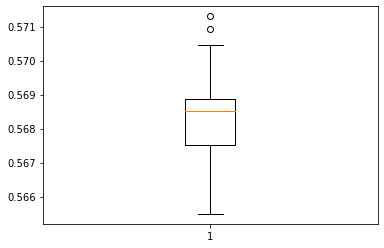

In [73]:
import matplotlib.pyplot as plt
import numpy as np
 
 
# Creating dataset
#data = np.random.normal(100, 20, 200)
 
#fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(mean_acc)
 
# show plot
plt.show()


In [74]:
from statistics import mean
mean_roc = []
for i in range(len(megamega_roc)):
  mean_roc.append(mean(megamega_roc[i]))
mean_roc #list of the mean acc of every fold 

[0.5966914303228924,
 0.5952460443545072,
 0.5936193774891795,
 0.5924726050824226,
 0.5933983829972793,
 0.5927946206613364,
 0.594562254432482,
 0.5928180870055816,
 0.5923085860890585,
 0.5929512393974316,
 0.5930115755950562,
 0.5952696945725015,
 0.5962648322133685,
 0.5946307272337867,
 0.5916788722545577,
 0.5949433583799973,
 0.5962651228325923,
 0.5962027513852622,
 0.5932514046352138,
 0.5956408136433539]

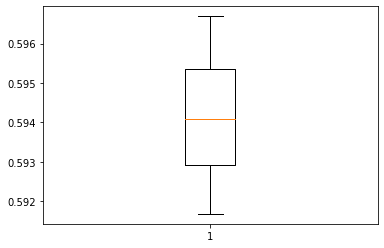

In [75]:

plt.boxplot(mean_roc)
plt.show()


###### till here #####


In [ ]:
print(len(mega_acc))

In [ ]:
print(len(mega_roc))

In [ ]:
print(mega_roc[0])

In [ ]:
print(mega_acc[0])

In [ ]:
from statistics import mean
print(mean(mega_acc[0]))

In [ ]:
from statistics import mean
temp=[]
for i in range(len(mega_acc)):
  temp.append(mean(mega_acc[i]))
print(mean(temp))

In [ ]:
temp

In [ ]:
from statistics import mean
print(mean(mega_roc[0]))

In [ ]:
from statistics import mean
temp1=[]
for i in range(len(mega_roc)):
  temp1.append(mean(mega_roc[i]))
print(mean(temp))

In [ ]:
temp1

left & left


correct code

In [ ]:
df11 = pd.read_csv('/content/left.txt', delimiter="\t")
df2 = pd.read_csv('/content/left.txt', delimiter="\t")
df = df11[0:2062]
df2=df11[2062:]


In [ ]:
df

In [ ]:
df2

In [ ]:
colnames2 = ["FoldID", "EventID", "start_index", "seq", "Bound"]
colnames = ["FoldID", "EventID", "seq", "Bound"]

#df =  motif 
#df2 = non motif
#df4 = mixed test file

#df = pd.read_csv('/content/left.txt', delimiter="\t")
#df2 = pd.read_csv('/content/right.txt', delimiter="\t")

df1 = list(df["seq"])
df3 = list(df2["seq"])
#df1.reset_index(drop=True, inplace=True)
#df3.reset_index(drop=True, inplace=True)
#df4 = pd.read_csv('/content/test1/mixed.txt', delimiter="\t")

#df4=df4.rename(columns=df4.iloc[0]).drop(df4.index[0])
#df4 = df4.sample(frac=1).reset_index(drop=True)
print('##### df head #####')
#print(df4.head())

motif_seq = df['seq'].to_list()
nonmotif_seq = df2['seq'].to_list()
print("Len of motif list: ", len(motif_seq))
print("Len of non motif list: ", len(nonmotif_seq))
X_motifs = motif_seq
y_motifs = [1 for i in range(len(motif_seq))]

X_nonmotifs = nonmotif_seq
y_nonmotifs = [0 for i in range(len(nonmotif_seq))]

kf = KFold(n_splits=8)
print(kf.get_n_splits(X_motifs))

all_train_index_motif, all_test_index_motif  = [], []
all_train_index_nonmotif, all_test_index_nonmotif  = [], []

#motif
for train_index, test_index in kf.split(X_motifs): 
  #print("TRAIN: ", train_index, "TEST: ", test_index)
  all_train_index_motif.append(train_index)
  all_test_index_motif.append(test_index)

#nonmotif
for train_index, test_index in kf.split(X_nonmotifs): 
  #print("TRAIN: ", train_index, "TEST: ", test_index)
  all_train_index_nonmotif.append(train_index)
  all_test_index_nonmotif.append(test_index)

print('##### len(all_train_index_motif[0]) #####')
print(len(all_train_index_motif[0]))
print('##### len(all_train_index_motif) #####')
print(len(all_train_index_motif))
print('##### len(all_train_index_nonmotif) #####')
print(len(all_train_index_nonmotif))
print('##### all_train_index_nonmotif[0] #####')
print(len(all_train_index_nonmotif[0]))
print('##### all_test_index_nonmotif #####')
print(len(all_test_index_nonmotif))
print('##### all_test_index_motif[0]) #####')
print(len(all_test_index_motif[0]))


mega_acc_left=[]
mega_roc_left=[]
#K FOLD loop - for the number of folds 
for i in range(kf.n_splits):
  l_motif=[]
  l_nonmotif=[]

  motif_seq=[]
  for a in all_train_index_motif[i]:
    motif_seq.append(X_motifs[a])

  nonmotif_seq=[]
  for a1 in all_train_index_nonmotif[i]:
    nonmotif_seq.append(X_nonmotifs[a1])
  

  for j in range(0,len(all_test_index_motif[i])):
    test_set_motif=X_motifs
    l_motif.append(X_motifs[all_test_index_motif[i][j]])
  for j in range(0,len(all_test_index_nonmotif[i])):
    test_set_nonmotif=X_nonmotifs
    l_nonmotif.append(X_nonmotifs[all_test_index_nonmotif[i][j]])

  l_1 =[1 for i in range(len(l_motif))]
  l_0 =[0 for i in range(len(l_nonmotif))]

  df_test= pd.DataFrame(list(zip(l_motif,l_1)),columns=['seq','Bound'])
  extra={'seq':l_nonmotif,'Bound':l_0}
  df_test= df_test.append(pd.DataFrame(extra))
  df_test=df_test.sample(frac=1).reset_index(drop=True)
  #print(df_test)

  acc1=[]
  roc1=[]
#training loop: 
  for i1 in range(5,6,1): #order of the markov models
    print("Step: ", i1)
    var = i1
    dict6 = train(motif_seq,nonmotif_seq,df_test)
    print("dict6",dict6)
    acc = accuracy(df_test)
    acc1.append(acc)
    print(acc)  
    y_true,y_pred = acc_score(df_test)
    confusion_mat(y_true,y_pred)
    #auc_calculate(df_test)
    auc=roc_calculate(df_test)
    print('printing auc in train function: ', auc)
    roc1.append(float(auc))
  mega_acc_left.append(acc1)
  mega_roc_left.append(roc1)


In [ ]:
print(len(mega_acc_left))

In [ ]:
print(len(mega_roc_left))

In [ ]:
print(mega_roc_left[0])

In [ ]:
print(mega_acc_left[0])

In [ ]:
from statistics import mean
print(mean(mega_acc_left[0]))

In [ ]:
from statistics import mean
temp_left=[]
for i in range(len(mega_acc_left)):
  temp_left.append(mean(mega_acc_left[i]))
print(mean(temp_left))

In [ ]:
from statistics import mean
print(mean(mega_roc_left[0]))

In [ ]:
from statistics import mean
temp1_left=[]
for i in range(len(mega_roc_left)):
  temp1_left.append(mean(mega_roc_left[i]))
print(mean(temp1_left))

acc temp - tad & left 
acc temp_left - left & left

In [ ]:
temp

In [ ]:
temp_left

In [ ]:
num = 0
for i in range(len(temp)):
  if(temp[i]>temp_left[i]):
    num+=1

num    

left & right

In [ ]:
colnames2 = ["FoldID", "EventID", "start_index", "seq", "Bound"]
colnames = ["FoldID", "EventID", "seq", "Bound"]

#df =  motif 
#df2 = non motif
#df4 = mixed test file

df = pd.read_csv('/content/left.txt', delimiter="\t")
df2 = pd.read_csv('/content/rigt.txt', delimiter="\t")

df1 = list(df["seq"])
df3 = list(df2["seq"])
#df1.reset_index(drop=True, inplace=True)
#df3.reset_index(drop=True, inplace=True)
#df4 = pd.read_csv('/content/test1/mixed.txt', delimiter="\t")

#df4=df4.rename(columns=df4.iloc[0]).drop(df4.index[0])
#df4 = df4.sample(frac=1).reset_index(drop=True)
print('##### df head #####')
#print(df4.head())

motif_seq = df['seq'].to_list()
nonmotif_seq = df2['seq'].to_list()
print("Len of motif list: ", len(motif_seq))
print("Len of non motif list: ", len(nonmotif_seq))
X_motifs = motif_seq
y_motifs = [1 for i in range(len(motif_seq))]

X_nonmotifs = nonmotif_seq
y_nonmotifs = [0 for i in range(len(nonmotif_seq))]

kf = KFold(n_splits=8)
print(kf.get_n_splits(X_motifs))

all_train_index_motif, all_test_index_motif  = [], []
all_train_index_nonmotif, all_test_index_nonmotif  = [], []

#motif
for train_index, test_index in kf.split(X_motifs): 
  #print("TRAIN: ", train_index, "TEST: ", test_index)
  all_train_index_motif.append(train_index)
  all_test_index_motif.append(test_index)

#nonmotif
for train_index, test_index in kf.split(X_nonmotifs): 
  #print("TRAIN: ", train_index, "TEST: ", test_index)
  all_train_index_nonmotif.append(train_index)
  all_test_index_nonmotif.append(test_index)

print('##### len(all_train_index_motif[0]) #####')
print(len(all_train_index_motif[0]))
print('##### len(all_train_index_motif) #####')
print(len(all_train_index_motif))
print('##### len(all_train_index_nonmotif) #####')
print(len(all_train_index_nonmotif))
print('##### all_train_index_nonmotif[0] #####')
print(len(all_train_index_nonmotif[0]))
print('##### all_test_index_nonmotif #####')
print(len(all_test_index_nonmotif))
print('##### all_test_index_motif[0]) #####')
print(len(all_test_index_motif[0]))


mega_acc_lr=[]
mega_roc_lr=[]
#K FOLD loop - for the number of folds 
for i in range(kf.n_splits):
  l_motif=[]
  l_nonmotif=[]

  motif_seq=[]
  for a in all_train_index_motif[i]:
    motif_seq.append(X_motifs[a])

  nonmotif_seq=[]
  for a1 in all_train_index_nonmotif[i]:
    nonmotif_seq.append(X_nonmotifs[a1])
  

  for j in range(0,len(all_test_index_motif[i])):
    test_set_motif=X_motifs
    l_motif.append(X_motifs[all_test_index_motif[i][j]])
  for j in range(0,len(all_test_index_nonmotif[i])):
    test_set_nonmotif=X_nonmotifs
    l_nonmotif.append(X_nonmotifs[all_test_index_nonmotif[i][j]])

  l_1 =[1 for i in range(len(l_motif))]
  l_0 =[0 for i in range(len(l_nonmotif))]

  df_test= pd.DataFrame(list(zip(l_motif,l_1)),columns=['seq','Bound'])
  extra={'seq':l_nonmotif,'Bound':l_0}
  df_test= df_test.append(pd.DataFrame(extra))
  df_test=df_test.sample(frac=1).reset_index(drop=True)
  #print(df_test)

  acc1=[]
  roc1=[]
#training loop: 
  for i1 in range(5,6,1): #order of the markov models
    print("Step: ", i1)
    var = i1
    dict6 = train(motif_seq,nonmotif_seq,df_test)
    print("dict6",dict6)
    acc = accuracy(df_test)
    acc1.append(acc)
    print(acc)  
    y_true,y_pred = acc_score(df_test)
    confusion_mat(y_true,y_pred)
    #auc_calculate(df_test)
    auc=roc_calculate(df_test)
    print('printing auc in train function: ', auc)
    roc1.append(float(auc))
  mega_acc_lr.append(acc1)
  mega_roc_lr.append(roc1)


In [ ]:
print(len(mega_acc_lr))

In [ ]:
print(len(mega_roc_lr))

In [ ]:
print(mega_roc_lr[0])

In [ ]:
print(mega_acc_lr[0])

In [ ]:
from statistics import mean
print(mean(mega_acc_lr[0]))

In [ ]:
from statistics import mean
temp_lr=[]
for i in range(len(mega_acc_lr)):
  temp_lr.append(mean(mega_acc_lr[i]))
print(mean(temp_lr))

In [ ]:
from statistics import mean
print(mean(mega_roc_lr[0]))

In [ ]:
from statistics import mean
temp1_lr=[]
for i in range(len(mega_roc_lr)):
  temp1_lr.append(mean(mega_roc_lr[i]))
print(mean(temp1_lr))

acc temp - tad & left 
acc temp_lr - left & right

In [ ]:
temp

In [ ]:
temp_lr

In [ ]:
num = 0
for i in range(len(temp)):
  if(temp[i]>temp_lr[i]):
    num+=1

num    

In [ ]:
_#tad generation

import pandas as pd
import numpy as np
arr = ['chromosome_num', 'chr1_num', 'chr2_num']
df = pd.read_csv('/content/GSE101317_S2Rplus_G1S_domain.txt', sep = '\t', names= arr)
tad = (df['chr1_num'] + df['chr2_num']) / 2
df2 = tad.to_frame()
df2 = df2.astype('int')
left = df2[0] - 100 
left.to_frame()
right = df2[0] + 100 
right.to_frame()
chrom_num = df['chromosome_num']
df = df.join(left).rename(columns={0: 'left'})
df = df.join(right).rename(columns={0: 'right'})
df = df.drop(columns=['chr1_num','chr2_num'])
df['.'] = df['chromosome_num'] + str(':') + df['left'].astype('str') + str('-') + df['right'].astype(str)

df.to_csv('tad.bed', header = None, index=None, sep='\t')
df

In [ ]:
df.to_csv('tads.bed', header=None, index=None, sep='\t')

In [ ]:

#left boundry 

arr = ['chromosome_num', 'chr1_num', 'chr2_num']
df = pd.read_csv("/content/GSE101317_S2Rplus_G1S_domain.txt", sep = '\t', names= arr)
lbx = (df['chr1_num'] - 700 )

lbx=lbx.to_frame()
lbx=lbx.rename(columns={'chr1_num':'LeftBoundaryX'})
df=df.join(lbx)

lby = (df['chr1_num'] - 500 )
lby=lby.to_frame()
lby=lby.rename(columns={'chr1_num':'LeftBoundaryY'})
df=df.join(lby)

df = df.drop(columns=['chr1_num','chr2_num'])
df['.'] = df['chromosome_num'] + str(':') +df['LeftBoundaryX'].astype('str') + str('-') + df['LeftBoundaryY'].astype(str)

df.to_csv('leftboundry.bed', header = None, index=None, sep='\t')
df


In [ ]:
#right boundry 

arr = ['chromosome_num', 'chr1_num', 'chr2_num']
df = pd.read_csv("/content/GSE101317_S2Rplus_G1S_domain.txt", sep = '\t', names= arr)
rbx = (df['chr2_num'] + 500 )

rbx=rbx.to_frame()
rbx=rbx.rename(columns={'chr2_num':'RightBoundryX'})
df=df.join(rbx)

rby = (df['chr2_num'] + 700 )
rby=rby.to_frame()
rby=rby.rename(columns={'chr2_num':'RightBoundryY'})
df=df.join(rby)
df = df.drop(columns=['chr1_num','chr2_num'])
df['.'] = df['chromosome_num'] + str(':') +df['RightBoundryX'].astype('str') + str('-') + df['RightBoundryY'].astype(str)

df.to_csv('rightboundry.bed', header = None, index=None, sep='\t')
df


In [ ]:
for i in range(kf.n_splits):
  print("YOOOOOOOOOOOOOOOOOOLLLLLLLLLLLLLLLLLLLLLLOOOOOOOOOOOOOOOOOOOOOO")
  for j in range(len(all_test_index_motif[i])):
    print(j)

In [ ]:
X=np.asarray([[1,2],[11,12],[21,22],[31,32],[41,42],[51,52],[61,62],[71,72],[81,82],[91,92]])
y=np.asarray([1],[2],[3],4,5,6,7,8,9,10])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))